In [7]:
import pandas as pd
from glob import glob
import os

# Directory where your data files are stored
data_dir = '../data/'

# Find all Excel files for 2024 data
data_files = glob(os.path.join(data_dir, '*_2024_ae_data.xls'))

# Define headers (if your spreadsheet doesn't have meaningful column names)
headers = [
    'Code', 'System', 'Type 1 Departments', 'Type 2 Departments', 'Type 3 Departments',
    'Total Attendances', 'Attendances < 4 hours (Type 1)', 'Attendances < 4 hours (Type 2)',
    'Attendances < 4 hours (Type 3)', 'Total Attendances < 4 hours', 'Attendances > 4 hours (Type 1)',
    'Attendances > 4 hours (Type 2)', 'Attendances > 4 hours (Type 3)', 'Total Attendances > 4 hours',
    'Percentage in 4 hours (all)', 'Percentage in 4 hours (Type 1)', 'Percentage in 4 hours (Type 2)',
    'Percentage in 4 hours (Type 3)', 'Emergency Admissions Type 1', 'Emergency Admissions Type 2',
    'Emergency Admissions Type 3 and 4', 'Total Emergency Admissions via A&E',
    'Other Emergency Admissions (not via A&E)', 'Total Emergency Admissions',
    'Patients spending >4 hours from decision to admit', 'Patients spending >12 hours from decision to admit'
]

# List to store all data
all_data_frames = []

# Read and clean each file
for file in data_files:
    # Extract month name from the filename (assuming format: "january_2024_ae_data.xls")
    file_name = os.path.basename(file)
    month_name = file_name.split('_')[0]  # Extract "january" from "january_2024_ae_data.xls"

    # Convert month name to a numeric month
    month_number = pd.to_datetime(month_name + ' 2024', format='%B %Y').month  

    # Read Excel file and skip metadata rows
    data = pd.read_excel(file, engine='xlrd', skiprows=17, header=None, names=headers)

    # Remove invalid rows (e.g., empty or placeholder rows)
    data = data[data['System'].notna() & (data['System'] != '-')]

    # Convert relevant columns to numeric
    numeric_columns = [
        'Total Attendances', 'Total Attendances < 4 hours', 'Total Attendances > 4 hours',
        'Emergency Admissions Type 1', 'Patients spending >4 hours from decision to admit'
    ]
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Drop rows with missing required data
    data = data.dropna(subset=['Total Attendances', 'Total Attendances < 4 hours'])

    # Add 'Month' column based on the filename
    data['Month'] = month_number

    # Add calculated field: Percentage Seen Within 4 Hours
    data['Percentage_Under_4_Hours'] = (data['Total Attendances < 4 hours'] / data['Total Attendances']) * 100

    # Append cleaned data to the list
    all_data_frames.append(data)

# Combine all monthly data into a single DataFrame
combined_data = pd.concat(all_data_frames, ignore_index=True)

# Save the combined dataset
combined_data.to_csv('../data/combined_2024_ae_data.csv', index=False)
print("Combined data saved to '../data/combined_2024_ae_data.csv'.")

# Preview the first few rows
print("\nFinal Combined Data Preview:")
print(combined_data.head())



Combined data saved to '../data/combined_2024_ae_data.csv'.

Final Combined Data Preview:
  Code                                             System  Type 1 Departments  \
0  QOX  NHS Bath And North East Somerset, Swindon And ...             17493.0   
1  QHG  NHS Bedfordshire, Luton And Milton Keynes Inte...             23953.0   
2  QHL  NHS Birmingham And Solihull Integrated Care Board             37306.0   
3  QUY  NHS Bristol, North Somerset And South Gloucest...             23459.0   
4  QU9  NHS Buckinghamshire, Oxfordshire And Berkshire...             34233.0   

   Type 2 Departments  Type 3 Departments  Total Attendances  \
0               355.0             10293.0            28141.0   
1                 0.0             16524.0            40477.0   
2                 0.0             16376.0            53682.0   
3              2252.0              7594.0            33305.0   
4              5268.0              8500.0            48001.0   

   Attendances < 4 hours (Type 1)  Att

In [12]:
from datetime import datetime

# Convert 'Month' column to a proper Date
combined_data['Date'] = pd.to_datetime(combined_data['Month'].astype(str) + '-01-2024')

# Define Full Moon Dates for 2024
full_moon_dates = [
    "2024-01-25", "2024-02-24", "2024-03-25", "2024-04-23", "2024-05-23", 
    "2024-06-21", "2024-07-21", "2024-08-19", "2024-09-17", "2024-10-17", 
    "2024-11-15", "2024-12-15"
]
full_moon_dates = [datetime.strptime(date, "%Y-%m-%d") for date in full_moon_dates]

# Function to check if a date is a full moon
def is_full_moon(date):
    return 1 if date.date() in [fm.date() for fm in full_moon_dates] else 0

# Apply the full moon feature
combined_data['is_full_moon'] = combined_data['Date'].map(is_full_moon)

# Define function for seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply season mapping
combined_data['season'] = combined_data['Month'].map(get_season)

# Define function for day/night (assumption: even months = Day, odd months = Night)
def day_or_night(month):
    return 'Day' if month % 2 == 0 else 'Night'

# Apply day/night feature
combined_data['day_or_night'] = combined_data['Month'].map(day_or_night)

# Save updated dataset
combined_data.to_csv('../data/combined_2024_ae_data_with_features.csv', index=False)

print("\n✅ Real Data Updated with New Features:")
print(combined_data[['Month', 'is_full_moon', 'season', 'day_or_night']].head())



✅ Real Data Updated with New Features:
   Month  is_full_moon  season day_or_night
0      2             0  Winter          Day
1      2             0  Winter          Day
2      2             0  Winter          Day
3      2             0  Winter          Day
4      2             0  Winter          Day



✅ Synthetic Data (Monthly Aggregates with Extra Features):
   Under_4_Hours  Over_4_Hours  Month
0            578           166      1
1            527           169      2
2            592           152      3
3            524           196      4
4            541           203      5


/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_86033/1468456190.py:60: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  synthetic_monthly = synthetic_df.resample('M').sum()[['Under_4_Hours', 'Over_4_Hours']]


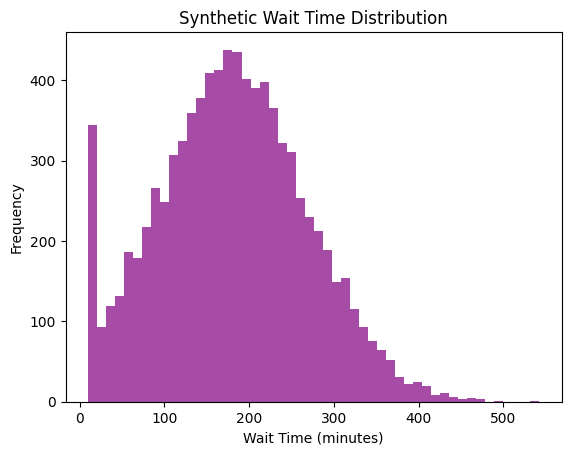

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set up the date range for synthetic data (Hourly for a year)
idx = pd.date_range(start='2024-01-01', end='2024-12-31', freq="h")

# Set a random seed for reproducibility
rng = np.random.default_rng(seed=42)

# Generate synthetic wait times using a normal distribution
wait_times = rng.normal(loc=180, scale=90, size=len(idx))
wait_times = np.clip(wait_times, 10, 600)  # Ensuring values are within a logical range

# Create DataFrame
synthetic_df = pd.DataFrame(index=idx, data=wait_times, columns=["wait_time_minutes"])

# Categorize into Under 4 Hours and Over 4 Hours
synthetic_df['Under_4_Hours'] = (synthetic_df['wait_time_minutes'] <= 240).astype(int)
synthetic_df['Over_4_Hours'] = (synthetic_df['wait_time_minutes'] > 240).astype(int)

# Full Moon Dates (2024 Full Moon Calendar)
full_moon_dates = [
    "2024-01-25", "2024-02-24", "2024-03-25", "2024-04-23", "2024-05-23", 
    "2024-06-21", "2024-07-21", "2024-08-19", "2024-09-17", "2024-10-17", 
    "2024-11-15", "2024-12-15"
]
full_moon_dates = [datetime.strptime(date, "%Y-%m-%d") for date in full_moon_dates]

# Function to check if a date is a full moon
def is_full_moon(date):
    return 1 if date.date() in [fm.date() for fm in full_moon_dates] else 0

# Apply full moon feature
synthetic_df['is_full_moon'] = synthetic_df.index.map(is_full_moon)

# Define Seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply season mapping
synthetic_df['season'] = synthetic_df.index.month.map(get_season)

# Define Day/Night Cycle
def day_or_night(hour):
    return 'Day' if 7 <= hour < 19 else 'Night'

# Apply day/night feature
synthetic_df['day_or_night'] = synthetic_df.index.hour.map(day_or_night)

# Aggregate by month for comparison
synthetic_monthly = synthetic_df.resample('M').sum()[['Under_4_Hours', 'Over_4_Hours']]
synthetic_monthly['Month'] = synthetic_monthly.index.month
synthetic_monthly.reset_index(drop=True, inplace=True)

# Show results
print("\n✅ Synthetic Data (Monthly Aggregates with Extra Features):")
print(synthetic_monthly.head())

# Visualize wait time distribution
plt.hist(wait_times, bins=50, color='purple', alpha=0.7)
plt.title("Synthetic Wait Time Distribution")
plt.xlabel("Wait Time (minutes)")
plt.ylabel("Frequency")
plt.show()
